In [1]:
import numpy as np 
import random 
import torch 
import os 
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import albumentations as A
from torch.utils.data import Dataset
import cv2 
import os 
from albumentations.pytorch.transforms import ToTensorV2

from typing import Literal
from tqdm import tqdm 
import matplotlib.pyplot as plt
import albumentations as A

In [3]:
def get_best_available_device():
    if torch.cuda.is_available():
        # Get the index of the CUDA device with the most free memory
        device = torch.device('cuda')
        gpu_memory = [torch.cuda.memory_reserved(i) - torch.cuda.memory_allocated(i) for i in range(torch.cuda.device_count())]
        best_gpu_index = torch.tensor(gpu_memory).argmax().item()
        device = torch.device(f'cuda:{best_gpu_index}')
    else:
        device = torch.device('cpu')
    return device

device = get_best_available_device()
print(f"Selected device: {device}")

Selected device: cuda:0


In [2]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['GLOBALSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
    
seed_everything(44)

In [3]:
def get_model(num_classes: int):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights='DEFAULT')
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one 
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256 #should be 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
    
    return model 

model = get_model(2)
    

In [21]:
image_dir = 'data/sofia_data/ground_truth_images'
images_boxes_dir = 'data/sofia_data/ground_truth_bounding_boxes'
images_ellipses_dir = 'data/sofia_data/ground_truth_projected_ellipses'

image_dir_items = [i.split(".")[0] for i in os.listdir(image_dir)]
images_ellipses_dir_items = [i.split(".")[0] for i in os.listdir(images_ellipses_dir)]
items = list(set(image_dir_items) & set(images_ellipses_dir_items))
items = sorted(items, key=lambda x: int(x.split('.')[0]))

images_name = [i+'.png' for i in items]
ellipses_name = [i+'.txt' for i in items]
bboxes_name = [i+'.txt' for i in items]

In [22]:
images_name[60]


'145.png'

In [23]:
transforms = [
    A.Normalize(),
    ToTensorV2()
]

In [36]:
class CraterDataset(Dataset):
    def __init__(self,
                 stage: Literal["train", "val", 'test'],
                 transforms
                 ):
        
        self.transforms = transforms
        
        self.images_dirpath = None
        self.labels_dirpath = None
        self.imgs_dir = image_dir
        self.images_ellipses_dir = images_ellipses_dir
        
        if stage == 'train':
            self.imgs = images_name[:80]  
            
        elif stage == 'val': 
            self.imgs = images_name[80:100]
        else: 
            self.imgs = images_name[100:120]
        
        self.classes = [_, 'crater']
        self.samples = os.listdir(self.labels_dirpath)
        
        if transforms:
            self.bbox_params = {
                "format":"pascal_voc",
                "min_area": 0,
                "min_visibility": 0,
                "label_fields": ["category_id"]
            }
            self.transforms = A.Compose(transforms, bbox_params=self.bbox_params)
    

    def __len__(self) -> int:
        return len(self.samples)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, dict]:
        img_name = self.imgs[idx]
        image_path = os.path.join(self.imgs_dir, img_name)
        img = cv2.imread(image_path)
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.images_ellipses_dir, annot_filename)
        
        target = self._get_target(annot_file_path)
        target["image_id"] = torch.tensor([idx])
        
        if self.transforms:
            img, target = self.transform(img, target)
        return img, target
        
    
    def transform(self, image: np.ndarray, target: dict) -> tuple[torch.Tensor, dict]:
        transformed = self.transforms(
            image=image, masks=target["masks"],
            bboxes=target["boxes"], 
            category_id=target["labels"]
        )
    
        image = transformed["image"]
        target["masks"] = torch.as_tensor(
            np.array(list(map(np.array, transformed["masks"])), dtype=np.uint8)
        ) 
        
        target["labels"] = torch.tensor(transformed["category_id"])
        target["boxes"] = torch.as_tensor(transformed["bboxes"], dtype=torch.float32)
        target["area"] = self.__get_area(target["boxes"])
        return image, target
    
    @staticmethod
    def _get_target_sample() -> dict:
        return {
            "boxes": [],
            "masks": [],
            "area": [],
            "labels": [],
            "iscrowd": None,
            "image_id": None
        }

    def _get_target(self, annotations_path: str) -> dict:
        target = self._get_target_sample()

        with open(annotations_path, "r") as f:
            lines = f.readlines()[1:]
            for line in lines:
                label = 1 
                data = line.strip().split(',')
                # Extract ellipse parameters
                x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation = map(float, data)
                rotation = np.degrees(rotation)
                mask = self.__get_mask(x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation)
                
                box = self.__get_box(mask)
                target["masks"].append(mask)    
                target["boxes"].append(box)
                target["labels"].append(label)
                
        num_objs = len(target["labels"])
        target["iscrowd"] = torch.zeros((num_objs,), dtype=torch.int64)
        return target 

    @staticmethod
    def __get_mask( x_centre, y_centre, semi_major_axis, semi_minor_axis, rotation) -> np.ndarray:
        mask = np.zeros((1024, 1024), dtype=np.uint8)
     
        cv2.ellipse(mask, (int(x_centre), int(y_centre)),
                    (int(semi_major_axis), int(semi_minor_axis)),
                    angle=rotation, startAngle=0, endAngle=360,
                    color=1, thickness=-1)
        
        return mask
    
    @staticmethod
    def __get_box(mask: np.ndarray):
        pos = np.nonzero(mask)
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        return [xmin, ymin, xmax, ymax]
    
    @staticmethod
    def __get_area(boxes) -> torch.Tensor:
         return (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

In [37]:
train_dataset = CraterDataset(
    stage="train",
transforms=transforms
)

In [38]:
val_dataset = CraterDataset(
    stage="val",
    transforms=transforms
)

In [39]:
from torch.utils.data import DataLoader

In [40]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=2, 
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

In [41]:
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=1, 
    shuffle=False,
    pin_memory=True,
    num_workers=4,
    collate_fn=lambda x: tuple(zip(*x))
)

In [42]:
from tqdm.notebook import tqdm
import torch.nn as nn
from torch import optim

class Trainer:
    def __init__(self,
                 model: nn.Module,
                 train_dataloader: DataLoader,
                 val_dataloader: DataLoader,
                 early_stop: dict = {"monitor": "loss_mask", "patience": 5},
                 save_every_epoch: int = 1,
                 save_dirpath: str = 'runs'
                ):
        
        # Callbacks | Early stoping & Model checkpoint
        self.patience = early_stop["patience"]
        self.monitor = early_stop["monitor"]
        self.track_list = []
        self.save_every_epoch = save_every_epoch
        self.save_dirpath = save_dirpath
        
        self.device = "cpu"
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.train_batches = len(train_dataloader)
        self.val_batches =  len(val_dataloader)
        
        self.model = model
        self.setup_model()
        
        self.optim_dict = self.configure_optimizers()
        self.optimizer = self.optim_dict["optimizer"]
        self.lr_scheduler = self.optim_dict["lr_scheduler"]
        
        self.step_outputs = {
            "loss_objectness": 0,
            "loss_mask": 0,
            "loss_classifier": 0,
            "loss_rpn_box_reg": 0,
            "loss_box_reg": 0,
            "loss": 0
        }
        
    def configure_optimizers(self) -> dict:
        # construct an optimizer
        params = [
            p
            for p in self.model.parameters()
            if p.requires_grad
        ]

        optimizer = optim.SGD(
            params,
            lr=0.0018,
            momentum=0.938,
            weight_decay=0.00053
        )

        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=3,
            gamma=0.1
        )
        return {
            "lr_scheduler": lr_scheduler,
            "optimizer": optimizer
        }
    
    def setup_model(self) -> None:
        for param in self.model.parameters():
            param.requires_grad = True
        self.model.to(self.device)
        self.model.train()
    
    def to_device(self, batch: tuple) -> tuple:
        images, targets = batch
        images = list(image.to(self.device) for image in images)

        targets = [
            {key: value.to(self.device) 
             for key, value in target.items()}
            for target in targets
        ]
        
        return images, targets
    
    def training_step(self, batch) -> dict:
        images, targets = self.to_device(batch)
        self.optimizer.zero_grad() 
        outputs = self.model(images, targets)
        loss = sum([loss for loss in outputs.values()])
        outputs["loss"] = loss
        loss.backward()
        self.optimizer.step()
        self.lr_scheduler.step()
        return outputs
    
    def validation_step(self, batch) -> dict:
        images, targets = self.to_device(batch)
        with torch.no_grad():
            outputs = self.model(images, targets)
            loss = sum([loss for loss in outputs.values()])
            outputs["loss"] = loss
        return outputs
    
    def shared_epoch_end(self, stage: str, epoch: int) -> float:
        tracked_loss = self.step_outputs[self.monitor]    
        loss_objectness = self.step_outputs["loss_objectness"]
        loss_mask = self.step_outputs["loss_mask"]
        loss_classifier = self.step_outputs["loss_classifier"]
        loss_rpn_box_reg = self.step_outputs["loss_rpn_box_reg"]
        loss_box_reg = self.step_outputs["loss_box_reg"]
        loss = self.step_outputs["loss"]
        
        print(
            f"""
            || End {epoch} {stage} epoch ||
            loss_objectness: {loss_objectness:.2f}
            loss_mask: {loss_mask:.2f}
            loss_classifier: {loss_classifier:.2f}
            loss_rpn_box_reg: {loss_rpn_box_reg:.2f}
            loss_box_reg: {loss_box_reg:.2f} 
            loss: {loss:.2f}\n
            """
        )
              
        self.step_outputs = self.step_outputs.fromkeys(self.step_outputs, 0)
        if stage == "val":
            return tracked_loss
              
    def on_train_epoch_end(self, epoch: int) -> None:
        return self.shared_epoch_end(stage="train", epoch=epoch)

    def on_validation_epoch_end(self, epoch: int) -> None:
        tracked_loss = self.shared_epoch_end(stage="val", epoch=epoch)
        patience = 0
        
        if epoch > self.patience:
            last_tracked = list(reversed(self.track_list))[:self.patience]
            for i in last_tracked:
                if i <= tracked_loss:
                    patience += 1
                    
        self.track_list.append(tracked_loss)
        return tracked_loss, (self.patience - patience)

    def train(self, max_epochs: int) -> None:
        
        for epoch in range(1, max_epochs + 1):
            for batch_idx, batch in tqdm(enumerate(self.train_dataloader, 1), desc="Training", total=self.train_batches, colour="#068e58"):
                outputs = self.training_step(batch)
                for key, value in outputs.items():
                    self.step_outputs[key] += float(value.detach().cpu().numpy()) / self.train_batches
            self.on_train_epoch_end(epoch)

            for batch_idx, batch in tqdm(enumerate(val_dataloader, 1), desc="Validation", total=self.val_batches, colour="#013385"):
                outputs = self.validation_step(batch)
                for key, value in outputs.items():
                    self.step_outputs[key] += float(value.detach().cpu().numpy()) / self.val_batches
            tracked_loss, patience = self.on_validation_epoch_end(epoch)
            
            if epoch % self.save_every_epoch == 0:
                if not os.path.exists(self.save_dirpath):
                    os.mkdir(self.save_dirpath)
                path = os.path.join(self.save_dirpath, f"epoch_{epoch}_{self.monitor}_{tracked_loss:.2f}.pt")
                torch.save(model.state_dict(), path) 
                print("\nThe model passed the save checkpoint successfully!\n")
                
            if patience == 0:
                print("Our patience has run out! Model training stopped beforehand.")
                break

In [43]:
trainer = Trainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    early_stop = {"monitor": "loss_mask", "patience": 5},
    save_every_epoch=1
)

In [ ]:
trainer.train(20)

In [44]:

checkpoint_path = 'runs/epoch_17_loss_mask_0.65.pt'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint)
model

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

predicted #boxes:  100
real #boxes:  106


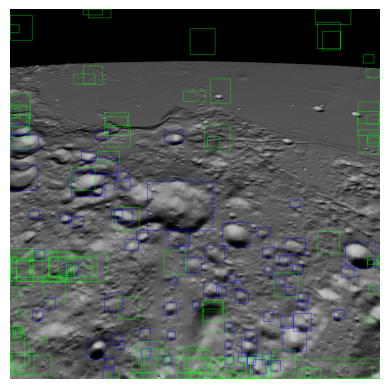

predicted #boxes:  100
real #boxes:  106


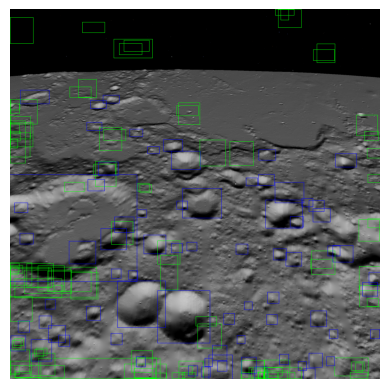

predicted #boxes:  100
real #boxes:  126


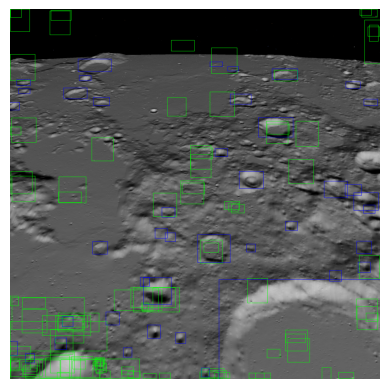

predicted #boxes:  100
real #boxes:  128


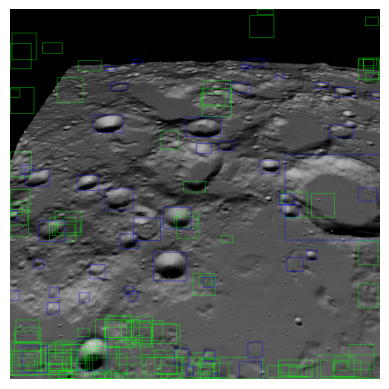

predicted #boxes:  100
real #boxes:  140


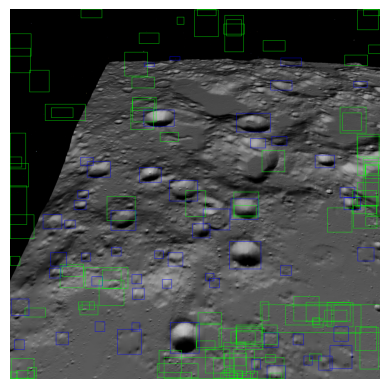

predicted #boxes:  100
real #boxes:  109


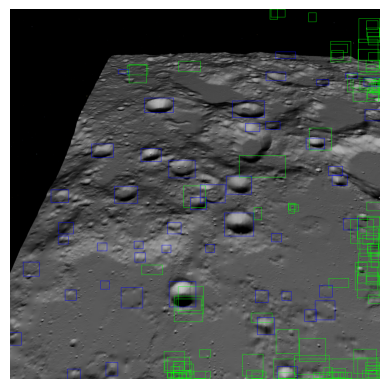

predicted #boxes:  100
real #boxes:  114


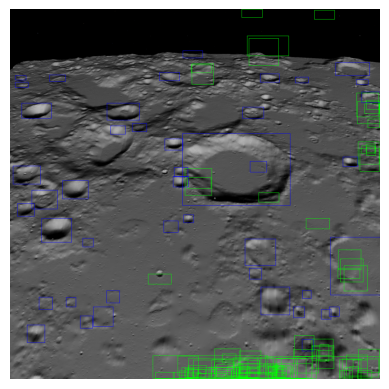

predicted #boxes:  100
real #boxes:  114


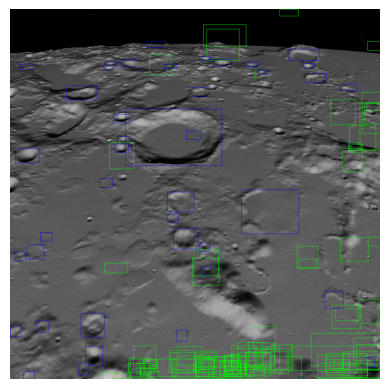

predicted #boxes:  100
real #boxes:  95


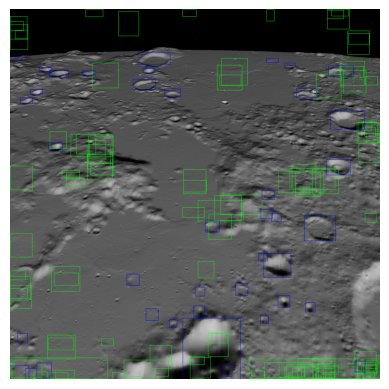

predicted #boxes:  100
real #boxes:  74


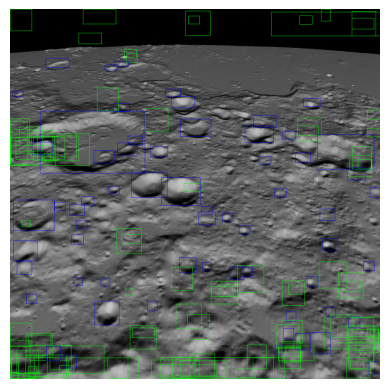

predicted #boxes:  100
real #boxes:  86


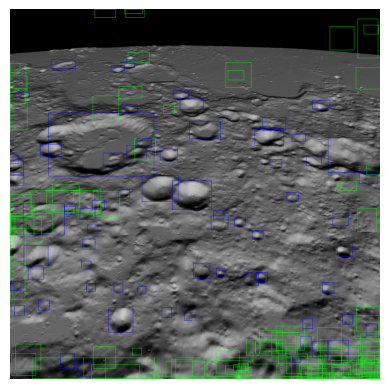

predicted #boxes:  100
real #boxes:  77


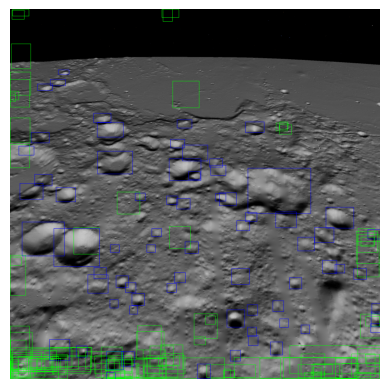

predicted #boxes:  100
real #boxes:  73


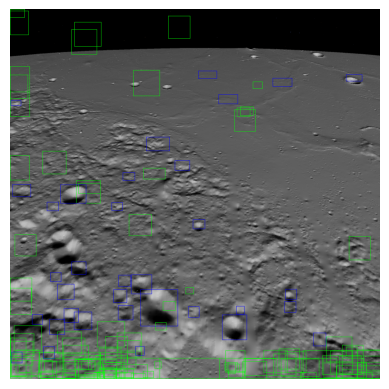

predicted #boxes:  100
real #boxes:  102


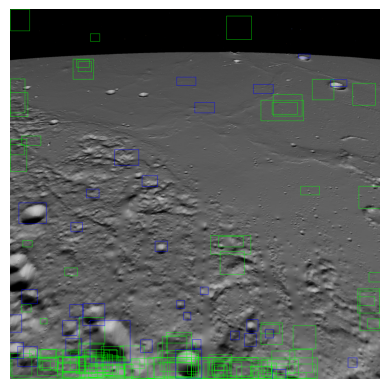

predicted #boxes:  100
real #boxes:  104


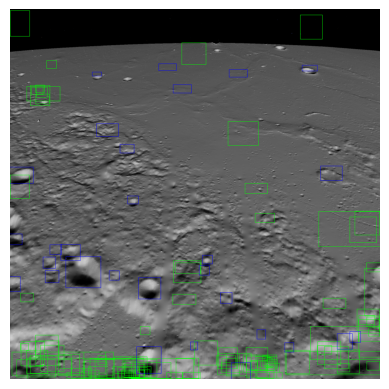

predicted #boxes:  100
real #boxes:  121


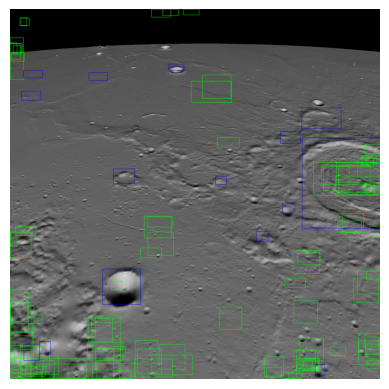

predicted #boxes:  100
real #boxes:  117


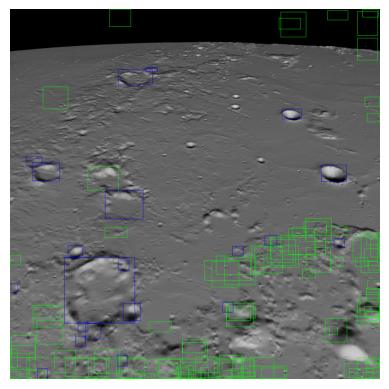

predicted #boxes:  100
real #boxes:  117


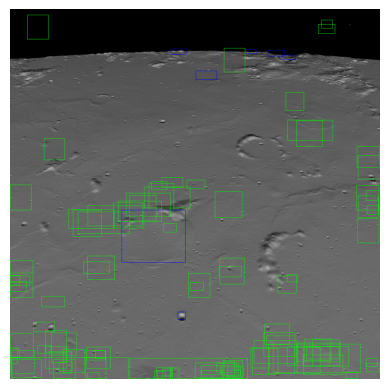

predicted #boxes:  100
real #boxes:  123


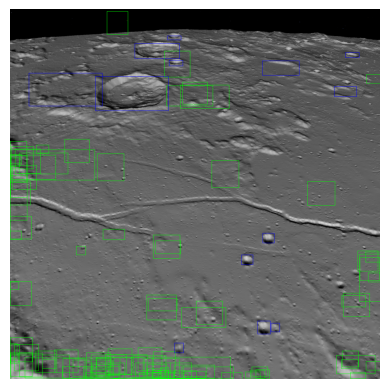

predicted #boxes:  100
real #boxes:  114


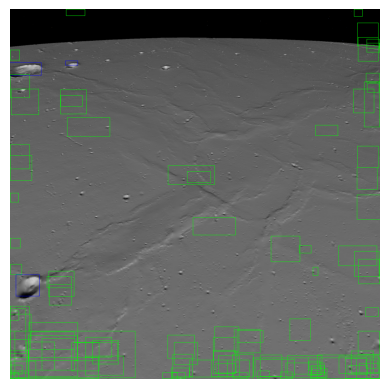

In [45]:
test_dataset = CraterDataset(stage="test",transforms=transforms)
test_image_names = images_name[1000:1200]
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

for img_idx in range(20):
    img, target = test_dataset[img_idx]
    real_img_idx = test_image_names[img_idx][:-4]

    model.eval()
    with torch.no_grad():
        img = img.to(device)  # Move input tensor to the same device as the model
        prediction = model([img])[0]

    print('predicted #boxes: ', len(prediction['labels']))
    print('real #boxes: ', len(target['labels']))

    target['image_id']

    
    test_image = cv2.imread(f'./data/sofia_data/ground_truth_images/{real_img_idx}.png')
    # test_image_scaled = cv2.resize(test_image, (256, 256))
    for box in prediction['boxes']:
        x1, y1, x2, y2 = box.tolist()
        # area = (x2 - x1) * (y2 - y1)
        
        cv2.rectangle(test_image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 1)

    images_boxes_path = os.path.join(images_boxes_dir, f'{real_img_idx}.txt')

    with open(images_boxes_path, 'r') as f:
        lines = f.readlines()[1:]
        for line in lines:
            data = line.strip().split(',')
            # Extract box parameters
            xmin, ymin, xmax, ymax = map(float, data)
            
            cv2.rectangle(test_image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 1)

    #####

    #####

    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()